In [1]:
# Modules import
import pandas as pd
import numpy as np
import os
import kagglehub
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split


In [2]:
# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)
df = pd.read_csv(os.path.join(path, "Combined Data.csv"))

100%|██████████| 11.1M/11.1M [00:00<00:00, 42.9MB/s]

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [3]:
# eliminate rows that don't have text to work with
df = df.loc[df.statement.isna() == False]

In [4]:
# Function to plot the Histogram of the classes
def print_class_histogram(df, text="", ax=None):
    class_totals = pd.concat([df.status.value_counts(), df.status.value_counts(normalize=True)], axis = 1)
    class_totals.columns = ["total", "percentage"]
    if ax == None:
        fig, ax = plt.subplots(1,1, figsize = (10,5))
    class_totals.total.plot(kind = "bar", title = text + " Histogram ", ax=ax)
    ax.set_xticklabels(class_totals.index, rotation = 0)
    ax.set_xlabel("Class")
    ax.set_ylabel("Count")
    for p in np.arange(len(class_totals.percentage.values)):
        ax.annotate(str(round(class_totals.percentage.values[p]*100,1)) + "%", (p, 100) , ha = 'center', color = "white")
        ax.annotate(f"{class_totals.total.values[p]:,}", (p, 1000) , ha = 'center', color = "Black")
    return ax

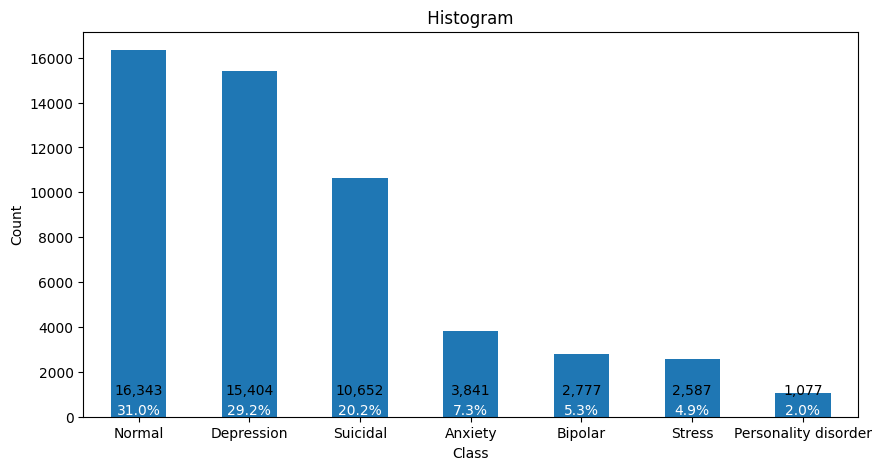

In [5]:
print_class_histogram(df)
plt.show()

In [6]:
# grouping the smaller clases
df_grouped = df.copy()
df_grouped.loc[df.status == 'Normal','status'] = 'normal'
df_grouped.loc[df.status == 'Depression','status'] = 'depression'
df_grouped.loc[(df.status == 'Suicidal') ,'status'] = 'suicidal'
df_grouped.loc[(df.status == 'Anxiety') | (df.status == 'Stress'),'status'] = 'other'
df_grouped.loc[(df.status == 'Bipolar') |(df.status == 'Personality disorder') ,'status'] = 'other'

df_grouped['status_factorized'] = df_grouped.status.factorize()[0]
label_dictionary = df_grouped.status.factorize()[1]

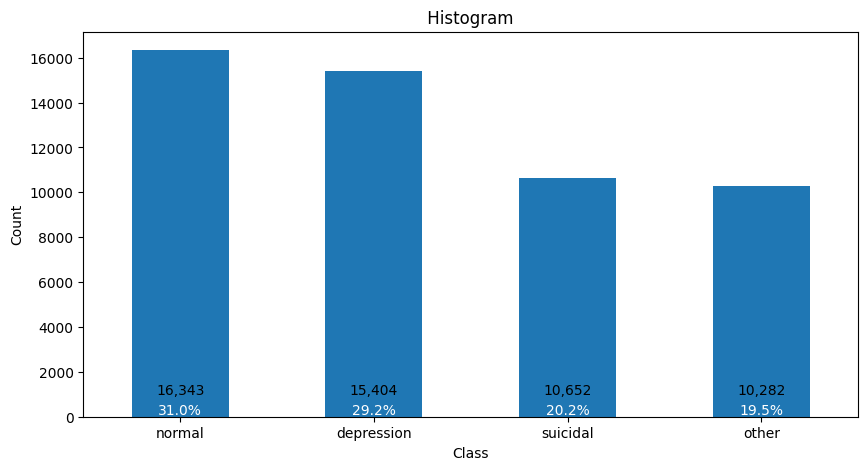

In [7]:
print_class_histogram(df_grouped)
plt.show()

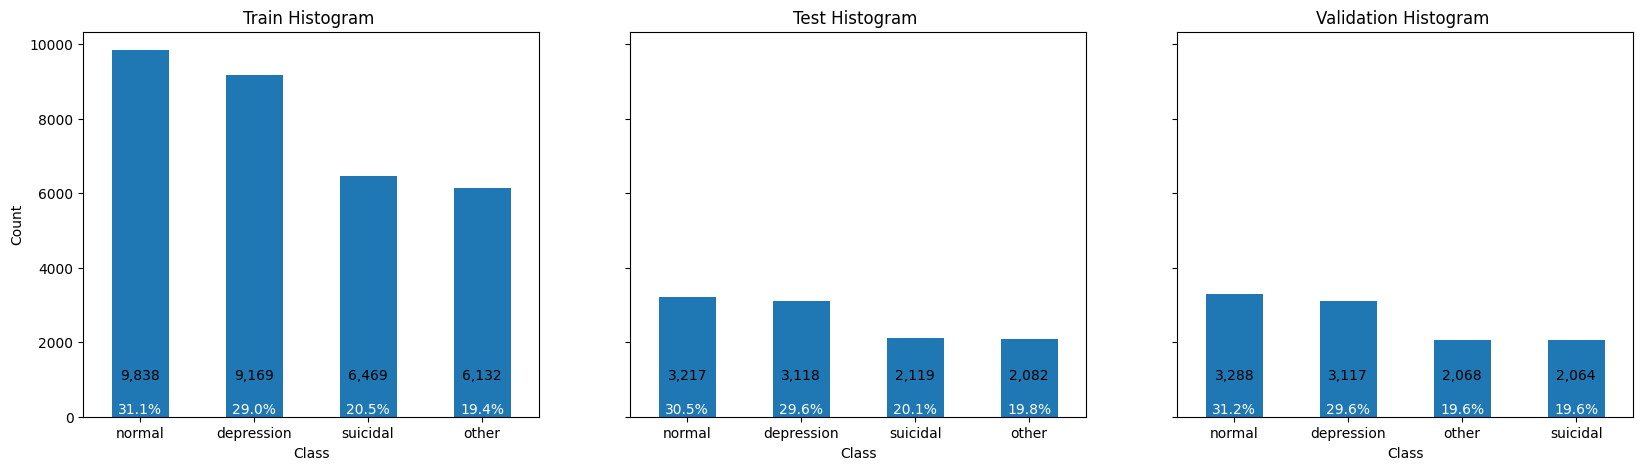

In [8]:
# Split data set into train, test, and validation

train_df, test_df = train_test_split(df_grouped, test_size=0.4, random_state=50)
test_df, val_df = train_test_split(test_df, test_size=0.5, random_state=50)

# Train data analysis
fig, ax = plt.subplots(1,3, figsize = (20,5), sharey =  True)
print_class_histogram(train_df, "Train", ax = ax[0])
print_class_histogram(test_df, "Test", ax = ax[1])
print_class_histogram(val_df, "Validation", ax = ax[2])
plt.show()


In [9]:
# Length of the statements measured in Number of tokens
train_df.statement.str.split().apply(lambda x: len(x)).describe(percentiles = [0.25, 0.5, 0.75, .85, 0.9, .95, 0.99])

,statement
count,31608.000000
mean,112.119558
std,158.674468
min,1.000000
25%,15.000000
50%,62.000000
75%,148.000000
85%,218.000000
90%,275.000000
95%,389.650000


In [10]:
# Data Processing and Vectorization
# Define variables
max_len = 390 # 726 for 99% of the statements, 390 for 95%
vocab_size = 1000

# Seting variables for training X and y
train_data = train_df.statement.values
train_labels = train_df.status.values

text_vecorization = tf.keras.layers.TextVectorization(max_tokens = vocab_size,
                                                      output_sequence_length = max_len,
                                                      output_mode= "int",
                                                      pad_to_max_tokens = True,
                                                      standardize = "lower_and_strip_punctuation"
                                                      )
text_vecorization.adapt(train_data)
vocabulary = text_vecorization.get_vocabulary()

In [11]:
print(f"Train data Shape  : {train_data.shape}")
print(f"Vocabulary size   : {text_vecorization.vocabulary_size()}")
print(f"Vocabulary top 20 : {vocabulary[:20]}")
print(f"Vocabulary last 20: {vocabulary[-20::-1]}")

Train data Shape  : (31608,)
Vocabulary size   : 1000
Vocabulary top 20 : ['', '[UNK]', 'i', 'to', 'and', 'the', 'my', 'a', 'of', 'it', 'not', 'is', 'me', 'have', 'that', 'am', 'in', 'do', 'but', 'for']
Vocabulary last 20: ['waking', 'busy', 'immediately', 'normally', 'guilt', 'till', 'ptsd', 'experiencing', '23', 'weed', 'ampx200b', 'comfortable', 'proud', 'seemed', 'eye', 'posting', 'aware', 'gonna', 'planning', 'tips', '16', 'anywhere', 'internet', 'mum', 'cat', 'joy', 'space', 'symptom', 'neck', 'running', 'stable', 'student', 'gives', 'extreme', 'notice', 'questions', 'hanging', 'killed', 'mania', 'themselves', 'funny', 'trouble', 'blame', 'step', 'fake', 'insurance', 'women', 'wont', 'worrying', 'degree', 'na', 'adult', 'process', 'amazing', 'unable', 'medical', 'ruined', 'exactly', 'avoid', '100', 'existence', 'asleep', 'period', 'related', 'toxic', 'relate', 'waste', 'youre', 'word', 'becoming', 'manage', 'sent', 'straight', 'anger', 'level', 'lie', 'perfect', 'honest', 'escape

In [12]:
# Define the vectorized datasets for training, validation and test.

train_data_v = text_vecorization(train_data)
val_data_v = text_vecorization(val_df.statement.values)
test_data_v = text_vecorization(test_df.statement.values)
train_labels_v = train_df.status_factorized.values
val_labels_v = val_df.status_factorized.values
test_labels_v = test_df.status_factorized.values

In [16]:
# Function to build the Transformer Encoder model
class TransformerEncoder(keras.layers.Layer):
    def __init__(self, embed_dim, dense_dim, num_heads, **kwargs):
        super().__init__(**kwargs)
        self.embed_dim = embed_dim
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.attention = tf.keras.layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.dense_proj = tf.keras.Sequential([
            tf.keras.layers.Dense(dense_dim, activation="relu"),
            tf.keras.layers.Dense(embed_dim),
        ])
        self.layernorm_1 = tf.keras.layers.LayerNormalization()
        self.layernorm_2 = tf.keras.layers.LayerNormalization()
        self.supports_masking = True

    def call(self, inputs, mask=None):
        if mask is not None:
            mask = mask[:, tf.newaxis, :]
        attention_output = self.attention(inputs, inputs, attention_mask=mask)
        proj_input = self.layernorm_1(inputs + attention_output)
        proj_output = self.dense_proj(proj_input)
        return self.layernorm_2(proj_input + proj_output)

    def get_config(self):
        config = super().get_config()
        config.update({
            "embed_dim": self.embed_dim,
            "num_heads": self.num_heads,
            "dense_dim": self.dense_dim,
        })
        return config

def build_Transformer_model(vocab_size, embedding_dim, dense_dim, num_heads, ff_dim, dropout_rate, learning_rate):
    tf.random.set_seed(42)
    tf.keras.backend.clear_session()
    inputs = tf.keras.layers.Input(shape=(None,), dtype=tf.int64)
    embedding = tf.keras.layers.Embedding(input_dim = vocab_size,      #Size of the vocabulary
                                          output_dim = embedding_dim,  # Dimensions of the dense embedding
                                          mask_zero=True               # Whether the 0s should be masked
                                          )(inputs)
    x = TransformerEncoder(embedding_dim, dense_dim, num_heads)(embedding)
    x = tf.keras.layers.GlobalAveragePooling1D()(x)
    x = tf.keras.layers.Dropout(dropout_rate)(x)
    outputs = tf.keras.layers.Dense(4, activation="softmax")(x)
    model = tf.keras.Model(inputs=inputs, outputs=outputs)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss="sparse_categorical_crossentropy", metrics=["accuracy"])
    return model

def plot_history(history):
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')


In [17]:
# Transformers
num_heads = 2 # self attention heads
ff_dim = 32 # Feed forward units in the transformer
# vocab_size = defined above
embedding_dim = 32 # number of dimensions of the embedding
dense_dim = 64 # number of units in the dense layer
dropout_rate = 0.2 # dropout percent after the transformer
batch_size = 32
epochs = 10
learning_rate = 0.01

# def build_Transformer_model(vocab_size, embedding_dim, dense_dim, num_heads, ff_dim, dropout_rate, learning_rate):

Transformer_model = build_Transformer_model(vocab_size = vocab_size,
                                            embedding_dim = embedding_dim,
                                            dense_dim = dense_dim,
                                            num_heads = num_heads,
                                            ff_dim = ff_dim,
                                            dropout_rate = dropout_rate,
                                            learning_rate = learning_rate)
print(Transformer_model.summary())

# adding early stopping
callbacks = [keras.callbacks.ModelCheckpoint("LSTM_model.keras", save_best_only=True),
             keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3)
             ]

history = Transformer_model.fit(train_data_v,
                         train_labels_v,
                         epochs=epochs,
                         batch_size= batch_size,
                         validation_data=(val_data_v,val_labels_v),
                         callbacks=callbacks)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, None)           │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ embedding (Embedding)     │ (None, None, 32)       │         32,000 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ not_equal (NotEqual)      │ (None, None)           │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ transformer_encoder       │ (None, None, 32)       │         12,736 │ embedding[0][0],       │
│ (TransformerEncoder)      │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ global_average_pooling1d  │ (None, 32)             │              0 │ transformer_encoder[0… │
│ (GlobalAveragePooling1D)  │                        │                │ not_equal[0][0]        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dropout_1 (Dropout)       │ (None, 32)             │              0 │ global_average_poolin… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ dense_2 (Dense)           │ (None, 4)              │            132 │ dropout_1[0][0]        │
└───────────────────────────┴────────────────────────┴────────────────┴────────────────────────┘

 Total params: 44,868 (175.27 KB)

 Trainable params: 44,868 (175.27 KB)

 Non-trainable params: 0 (0.00 B)

None
Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'query' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'key' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/keras/src/layers/layer.py:934: UserWarning: Layer 'value' (of type EinsumDense) was passed an input with a mask attached to it. However, this layer does not support masking and will therefore destroy the mask information. Downstream layers will not see the mask.
  warnings.warn(


988/988 ━━━━━━━━━━━━━━━━━━━━ 547s 548ms/step - accuracy: 0.6527 - loss: 0.8395 - val_accuracy: 0.7653 - val_loss: 0.5763
Epoch 2/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 492s 499ms/step - accuracy: 0.7678 - loss: 0.5820 - val_accuracy: 0.7719 - val_loss: 0.5677
Epoch 3/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 515s 522ms/step - accuracy: 0.7779 - loss: 0.5543 - val_accuracy: 0.7721 - val_loss: 0.5557
Epoch 4/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 481s 487ms/step - accuracy: 0.7802 - loss: 0.5514 - val_accuracy: 0.7637 - val_loss: 0.5885
Epoch 5/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 550s 536ms/step - accuracy: 0.7812 - loss: 0.5450 - val_accuracy: 0.7777 - val_loss: 0.5609
Epoch 6/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 530s 536ms/step - accuracy: 0.7858 - loss: 0.5340 - val_accuracy: 0.7710 - val_loss: 0.5686
Epoch 7/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 499s 505ms/step - accuracy: 0.7793 - loss: 0.5406 - val_accuracy: 0.7693 - val_loss: 0.5802
Epoch 8/10
988/988 ━━━━━━━━━━━━━━━━━━━━ 528s 531ms/step - accuracy: 0.7830 - loss: 0.53

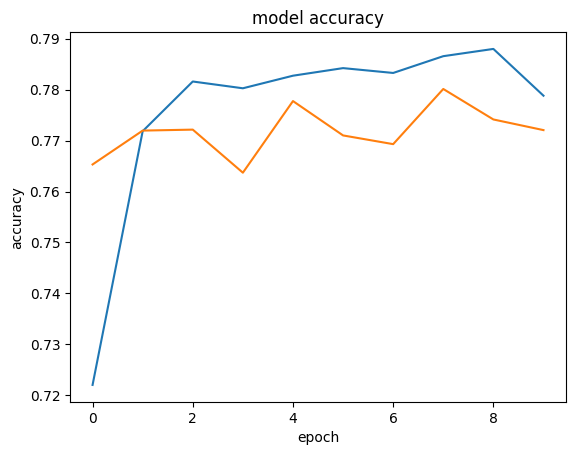

In [18]:
plot_history(history)
